Author: Ondřej Podsztavek

# Problem Specification

Given whole number $n$ (number of things), whole number $M$ (knapsack capacity),
finite set $W = \{w_1, w_2, \dots , w_n\}$ (things' weights),
finite set $C = \{c_1, c_2, \dots , c_n\}$ (things' price).
Construct set $X = \{x_1, x_2, \dots , x_n\}$ where all $x_i \in \{0, 1\}$,
so that $w_1 x_1 + w_2 x_2 + \dots + w_n x_n \leq M$ (knapsack is not overloaded)
and expression $c_1 x_1 + c_2 x_2 + \dots + c_n x_n$ is maximal for all such sets
(price of things in knapsack is maximal).

# Analysis of Possible Solution Variants

This section provides descriptions of possible methods for solving the knapsack problem:

1. *Brute force method* tries all possible configurations and return optimal solution.
2. *Heuristic method* is based on  inserting according to ratio of price and weight. Solution by heuristic fill the knapsack fast, but it can find suboptimal solution. 
3. *Branch and bound method* which has same time complexity as brute force mehtod but provides two optimalizations.
4. *Dynamic programming (decomposition by overall value)* is pseudo-polynomial algorithm and it returns optimal solution.
5. *FPTAS algorithm for knapsack problem* allows to solve the problem with choosen error and the time complexity is not going to grow worse the polynomial.

In [1]:
import knapsack as knap
import ast
import timeit
import time
import glob
import pandas
import numpy
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
from functools import partial

In [2]:
%matplotlib inline

In [3]:
def read_all_instances():
    instances = dict()
    for filename in glob.iglob('data/knap_??.inst.dat'):
        with open(filename) as f:
            instances.update(knap.read_instances(f))

    return pandas.DataFrame.from_dict(instances, orient='index')

In [4]:
def read_solutions(f):
    data = {}
    for line in f.readlines():
        items = list(map(int, line.split()))
        data[items[0]] = {
            'solution_value': items[2],
            'solution': items[3:]
        }
    return data

In [5]:
def read_all_solutions():
    solutions = dict()
    for filename in glob.iglob('data/knap_??.sol.dat'):
        with open(filename) as f:
            solutions.update(read_solutions(f))
    return pandas.DataFrame.from_dict(solutions, orient='index')

In [6]:
def backup_dataframe():
    # save DataFrame
    df.to_csv('data/dataframe-backup.csv')

In [7]:
# restore DataFrame
generic = lambda x: ast.literal_eval(x)
converters = {
    'weights': generic,
    'values': generic,
    'solution': generic
}
df = pandas.read_csv('data/dataframe-backup.csv', index_col=0, converters=converters)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 9000 to 9599
Data columns (total 18 columns):
n                            600 non-null int64
m                            600 non-null int64
weights                      600 non-null object
values                       600 non-null object
heuristic_time               600 non-null float64
brute_force_time             300 non-null float64
solution_value               600 non-null int64
solution                     600 non-null object
heuristic_value              600 non-null float64
relative_error               600 non-null float64
branch_and_bound_time        600 non-null float64
branch_and_bound_value       600 non-null float64
dynamic_programming_value    600 non-null float64
dynamic_programming_time     600 non-null float64
fptas_0.5_value              600 non-null float64
fptas_0.75_value             600 non-null float64
fptas_0.25_value             600 non-null float64
fptas_0.1_value              600 non-null float64


,n,m,weights,values,heuristic_time,brute_force_time,solution_value,solution,heuristic_value,relative_error,branch_and_bound_time,branch_and_bound_value,dynamic_programming_value,dynamic_programming_time,fptas_0.5_value,fptas_0.75_value,fptas_0.25_value,fptas_0.1_value
9000,4,100,"[18, 42, 88, 3]","[114, 136, 192, 223]",0.000037,0.000055,473,"[1, 1, 0, 1]",473.0,0.000000,0.000030,473.0,473.0,0.031192,473.0,473.0,473.0,473.0
9001,4,100,"[55, 81, 14, 52]","[29, 64, 104, 222]",0.000030,0.000055,326,"[0, 0, 1, 1]",326.0,0.000000,0.000037,326.0,326.0,0.016173,326.0,326.0,326.0,326.0
9002,4,100,"[89, 18, 57, 69]","[196, 62, 34, 112]",0.000027,0.000051,196,"[1, 0, 0, 0]",174.0,0.112245,0.000040,196.0,196.0,0.015611,196.0,196.0,196.0,196.0
9003,4,100,"[34, 23, 62, 2]","[169, 152, 44, 224]",0.000029,0.000059,545,"[1, 1, 0, 1]",545.0,0.000000,0.000035,545.0,545.0,0.022405,545.0,545.0,545.0,545.0
9004,4,100,"[67, 74, 87, 65]","[145, 111, 139, 243]",0.000023,0.000061,243,"[0, 0, 0, 1]",243.0,0.000000,0.000030,243.0,243.0,0.023797,243.0,243.0,243.0,243.0


In [8]:
ns = [4, 10, 15, 20, 22, 25, 27, 30, 32, 35, 37, 40]

In [9]:
def time_instances(fn, ns, df, time_column):
    for n in ns:
        for idx, inst in df[df['n'] == n].iterrows():
            global inst_fn  # TODO global allows to make import from __main__
            inst_fn = partial(fn, *inst[['n', 'm', 'weights', 'values']])
            timer = timeit.Timer('inst_fn()', setup='from __main__ import inst_fn', timer=time.process_time)
            t = timer.timeit(number=1)
            df.loc[idx, time_column] = t
            print(idx, inst['n'], t)

## Brute Force Method

This method remember the best cost of solution and corresponding configurations.
For every configuration it check the constrain and compute the optimization criterion.
Its value is compared to the best value computed so far and if needed the best value is modified.
After testing all configurations the method has the optimal solution saved.
Complexity of this method is $\Theta(n2^n)$ where $n$ is instance size because count of all possible knapsack
fillings is $2^n$ and for each of them constrain and optimization criterion has to be computed in time $\Theta(n)$.

In [10]:
time_instances(knap.brute_force, [], df, 'brute_force_time')

## Heuristic Method

This method calculates ratio of price and weight ($\frac{c_i}{w_i}$) for each thing.
According to this ratio the thing are sorted in descending order
(if the ratio is the same then the lighter thing is preferred).
Things are inserted into the knapsack in the sorted order until the knapsack is full.
Heuristic method's complexity is $O(n\log{n})$ because complexity of sorting Python function `sorted()` is
$O(n\log{n})$ (viz [Timsort](https://en.wikipedia.org/wiki/Timsort))
and complexity of knapsack filling is only $O(n)$.

In [11]:
time_instances(knap.heuristic, [], df, 'heuristic_time')

In [12]:
def solve_instances(fn, ns, df, solution_column):
    for n in ns:
        for idx, inst in df[df['n'] == n].iterrows():
            value, _ = fn(*inst[['n', 'm', 'weights', 'values']])
            df.loc[idx, solution_column] = value
            print(idx, inst['n'], value)

In [13]:
solve_instances(knap.heuristic, [], df, 'heuristic_value')

In [14]:
def heuristic_relative_error():
    df['relative_error'] = (df['solution_value'] - df['heuristic_value']) / df['solution_value']

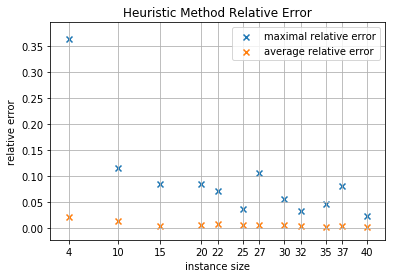

In [16]:
group = df.groupby(by='n')['relative_error']
mean_error = group.mean()
max_error = group.max()

ax = pyplot.subplot()
ax.set_title('Heuristic Method Relative Error')
ax.scatter(ns, max_error, marker='x', label='maximal relative error')
ax.scatter(ns, mean_error, marker='x', label='average relative error')
ax.set_xticks(ns)
ax.set_ylabel('relative error')
ax.set_xlabel('instance size')
ax.legend()
ax.grid()

pyplot.savefig('img/heuristic_relative_error.pdf')

## Branch and Bound

This method works similarly as brute force method. It recursively solves the problem. If in some recursive step the weight of things in knapsack is higher then its capacity the branch is discarted. Secondly, the methods holds the best value obtained so far. A branch is ended if in some recursive step value of undecided things cannot improve the best value. The recursive tree can be prune a lot but time complexity of this algorithm is still $O(2^n)$.

In [53]:
time_instances(knap.branch_and_bound, [], df, 'branch_and_bound_time')

In [18]:
solve_instances(knap.branch_and_bound, [], df, 'branch_and_bound_value')
(df['branch_and_bound_value'] == df['solution_value']).all()

True

## Dynamic Programming

TODO

In [19]:
time_instances(knap.dynamic_programming, [], df, 'dynamic_programming_time')

In [21]:
solve_instances(knap.dynamic_programming, [], df, 'dynamic_programming_value')
(df['dynamic_programming_value'] == df['solution_value']).all()

True

## FPTAS (Fully Polynomial-Time Approximation Scheme)

TODO

In [23]:
for e in [0.5, 0.25, 0.1]:
    time_instances(partial(knap.fptas, relative_error=e), [], df, 'fptas_' + str(e) + '_time')
    solve_instances(partial(knap.fptas, relative_error=e), [], df, 'fptas_' + str(e) + '_value')

# Measured Results

Table below contains average CPU time of computations of each instance sizes.
Measuring was carried out on processor *Intel(R) Core(TM) i5-3337U CPU @ 1.80GHz*.
Times for brute force method on instance of size 27 where not possible to measure because of computational complexity.

instance size | brute force, CPU time ($s$) | heuristic, CPU time ($s$) | branch and bound, CPU time ($s$) | dynamic programming, CPU time ($s$)
--:|-----------:|---------:| --------:|---------:
4  |   0.000038 | 0.000026 | 0.000032 | 0.019083
10 |   0.002232 | 0.000027 | 0.000184 | 0.128957
15 |   0.102152 | 0.000035 | 0.000281 | 0.226531
20 |   3.788610 | 0.000044 | 0.002965 | 0.461762
22 |  16.176022 | 0.000058 | 0.009661 | 0.530528
25 | 138.542621 | 0.000064 | 0.021655 | 0.704964
27 |            | 0.000055 | 0.035915 | 0.772885
30 |            | 0.000059 | 0.117377 | 0.942580
32 |            | 0.000070 | 0.222888 | 1.069233
35 |            | 0.000064 | 0.659761 | 1.259632
37 |            | 0.000058 | 0.737257 | 1.397729
40 |            | 0.000058 | 4.032605 | 1.658905

Figure 1 shows dependence of time on instance size.
Figure 2 shows dependence of relative error on instance size.
Relative error $\epsilon$ is calculated as $\epsilon = \frac{c(\text{opt}) - c(\text{apx})}{c(\text{opt})}$,
where $c(\text{opt})$ is cost of optimal and $c(\text{apx})$ is cost of suboptimal solution.

![Figure 1: Brute force and heuristic method average computational CPU time.](img/brute_force_heuristic_times.pdf)

![Figure 2: Heuristic method relative error.](img/heuristic_relative_error.pdf)

In [61]:
times_mean['dynamic_programming_time']

n
4     0.019083
10    0.128957
15    0.226531
20    0.461762
22    0.530528
25    0.704964
27    0.772885
30    0.942580
32    1.069233
35    1.259632
37    1.397729
40    1.658905
Name: dynamic_programming_time, dtype: float64

In [54]:
times_idx = ['brute_force_time', 'heuristic_time', 'branch_and_bound_time', 'dynamic_programming_time',
             'fptas_0.5_time', 'fptas_0.25_time', 'fptas_0.1_time']
times_group = df.groupby(by='n')[times_idx]
times_mean = times_group.mean()
times_std = times_group.std()
times_mean

,brute_force_time,heuristic_time,branch_and_bound_time,dynamic_programming_time,fptas_0.5_time,fptas_0.25_time,fptas_0.1_time
n,,,,,,,
4,0.000038,0.000026,0.000032,0.019083,0.000908,0.001623,0.003787
10,0.002232,0.000027,0.000184,0.128957,0.011387,0.020090,0.050181
15,0.102152,0.000035,0.000281,0.226531,0.037538,0.060854,0.145518
20,3.788610,0.000044,0.002965,0.461762,0.089155,0.140829,0.342327
22,16.176022,0.000058,0.009661,0.530528,0.095749,0.180159,0.478413
25,138.542621,0.000064,0.021655,0.704964,0.135837,0.309871,0.691213
27,NaN,0.000055,0.035915,0.772885,0.164916,0.334847,0.819459
30,NaN,0.000059,0.117377,0.942580,0.239953,0.460975,1.148475
32,NaN,0.000070,0.222888,1.069233,0.311098,0.536905,1.346134


In [55]:
times_std

,brute_force_time,heuristic_time,branch_and_bound_time,dynamic_programming_time,fptas_0.5_time,fptas_0.25_time,fptas_0.1_time
n,,,,,,,
4,0.000012,0.000007,0.000009,0.005649,0.000290,0.000387,0.001065
10,0.000404,0.000005,0.000121,0.037941,0.003347,0.003711,0.008956
15,0.014299,0.000011,0.000487,0.042246,0.010832,0.011280,0.025310
20,0.241654,0.000013,0.003910,0.101599,0.018531,0.023008,0.055061
22,0.804018,0.000021,0.013283,0.100791,0.018544,0.028308,0.097470
25,3.342785,0.000021,0.019179,0.154486,0.022117,0.066970,0.131161
27,NaN,0.000017,0.044135,0.137328,0.027394,0.054848,0.127746
30,NaN,0.000016,0.124169,0.148166,0.045620,0.071965,0.177318
32,NaN,0.000022,0.500484,0.196747,0.064127,0.085291,0.219882


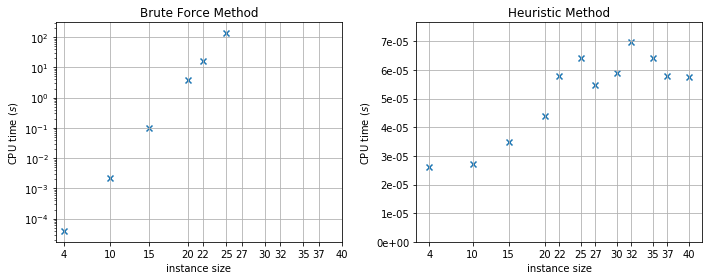

In [56]:
fig, (ax1, ax2) = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 4))
# brute force
ax1.set_yscale('log')
ax1.scatter(ns, times_mean['brute_force_time'], marker='x')
ax1.set_title('Brute Force Method')
ax1.set_xticks(ns)
ax1.set_xlabel('instance size')
ax1.set_ylabel('CPU time ($s$)')
ax1.grid()

# heuristic
ax2.scatter(ns, times_mean['heuristic_time'], marker='x')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.e'))
ax2.set_ylim([0, 1.1 * times_mean['heuristic_time'].max()])
ax2.set_title('Heuristic Method')
ax2.set_xticks(ns)
ax2.set_xlabel('instance size')
ax2.set_ylabel('CPU time ($s$)')
ax2.grid()

fig.tight_layout()
pyplot.savefig('img/brute_force_heuristic_times.pdf')

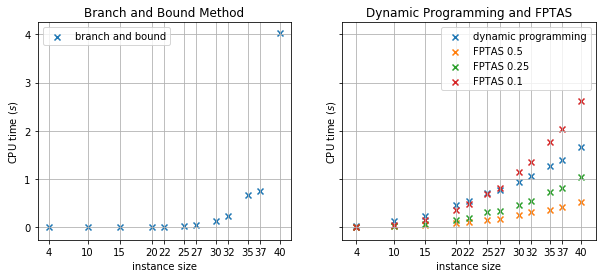

In [58]:
fig, (ax1, ax2) = pyplot.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))

ax1.set_title('Branch and Bound Method')
ax1.scatter(ns, times_mean['branch_and_bound_time'], marker='x', label='branch and bound')
ax2.scatter(ns, times_mean['dynamic_programming_time'], marker='x', label='dynamic programming')

ax2.set_title('Dynamic Programming and FPTAS')
ax2.scatter(ns, times_mean['fptas_0.5_time'], marker='x', label='FPTAS 0.5')
ax2.scatter(ns, times_mean['fptas_0.25_time'], marker='x', label='FPTAS 0.25')
ax2.scatter(ns, times_mean['fptas_0.1_time'], marker='x', label='FPTAS 0.1')

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xticks(ns)
    ax.set_xlabel('instance size')
    ax.set_ylabel('CPU time ($s$)')
    ax.grid()

# Conclusion

From measured data is obvious that for big instances is use of brute force method not usable because of vast computational complexity.
On contrary for small instances brute force can find optimal solutions relatively fast.

Heuristic method is able to solve fast instances of all sizes.
Growth of computational complexity is acceptable.
From figure 2 can be inferred that as size of instance grows so the relative error is smaller
and thus the suboptimal solutions are better.

Therefore brute force method should be use fro small instances
and heuristic method is good for instances
where the computational time of brute force method is not acceptable.